In [9]:
from utilities import *
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import wcs
from astropy.wcs import WCS
import math
from astropy import coordinates
import radio_beam

def make_scalebar(ax, left_side, length, color='black', linestyle='-', label='',
                  fontsize=12, text_offset=0.1*u.arcsec, coordsys='icrs'):
    axlims = ax.axis()
    lines = ax.plot(u.Quantity([left_side.ra, left_side.ra-length]),
                    u.Quantity([left_side.dec]*2),
                    color=color, linestyle=linestyle, marker=None,
                    transform=ax.get_transform(coordsys),
                   zorder=3)
    txt = ax.text((left_side.ra-length/2).to(u.deg).value,
                  (left_side.dec+text_offset).to(u.deg).value,
                  label,
                  verticalalignment='bottom',
                  horizontalalignment='center',
                  transform=ax.get_transform(coordsys),
                  color=color,
                  fontsize=fontsize,
                 zorder=2,bbox=dict(facecolor='white', alpha=0.6))
    ax.axis(axlims)
    return lines,txt
source='DSi'
fnum=fields[source]
c2h5oh_sourcelocations={'DSi':'/oct2024_1_removesDS2exclusions/','DSii':'/oct2024_1_removeproblemlines/','DSVI':'/sep2024_2_removechisquared/'}
ethanolhome=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/C2H5OH/{source}'
methanolhome=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/CH3OH/{source}'
ethanol_dataversion=c2h5oh_sourcelocations[source]
methanolversion=ch3oh_sourcedict[source]

scaledict={'SgrB2S':5000*u.AU,'DSi':5000*u.AU,'DSii':2000*u.AU,'DSiii':2000*u.AU,'DSiv':2000*u.AU,'DSv':2000*u.AU,'DSVI':5000*u.AU,'DSVII':5000*u.AU,'DSVIII':5000*u.AU,'DSIX':5000*u.AU,'DSX':5000*u.AU}
scale=scaledict[source]
lenn=np.arctan(scale/dGC)

epath=ethanolhome+f'{ethanol_dataversion}ntotmap_allspw_withnans_weighted_useintercept_3sigma.fits'
error_epath=ethanolhome+f'{ethanol_dataversion}ntoterrmap_allspw_withnans_weighted_useintercept.fits'

mpath=methanolhome+f'{methanolversion}bootstrap_ntot_intstd_boostrap1000_nonegativeslope.fits'
error_mpath=methanolhome+f'{methanolversion}error_ntot_intstd_boostrap1000_nonegativeslope.fits'
cntrfile='/orange/adamginsburg/sgrb2/2017.1.00114.S/imaging_results/Sgr_B2_DS_B6_uid___A001_X1290_X46_continuum_merged_12M_robust2_selfcal4_finaliter_feathered_with_bolocam.fits'

ethanolhdu=fits.open(epath)[0]
ethanol=ethanolhdu.data
error_ethanol=np.squeeze(fits.getdata(error_epath))
methanol=np.squeeze(fits.getdata(mpath))
error_methanol=np.squeeze(fits.getdata(error_mpath))
plotwcs=WCS(ethanolhdu.header)
beam=radio_beam.Beam.from_fits_header(ethanolhdu.header)

cntrhdu=fits.open(cntrfile)[0]
cntrrms=0.0002#Jy
cntrlist=cntrrms*np.array([5,9,27,81,128,281])

contourwcs=WCS(cntrhdu).celestial
cntrdata=np.squeeze(cntrhdu.data)

savefigbase=f'/blue/adamginsburg/d.jeff/repos/C2H5OH_SgrB2DS/figures/{source}'
savefighome=savefigbase+c2h5oh_sourcelocations[source]
savefigpath=savefighome+'ethanolmethanolratio_3sigma.png'

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [10]:
ratio=ethanol/methanol
error_ratio=np.sqrt((error_ethanol/methanol)**2+((-ethanol/(methanol**2))*error_methanol)**2)#From partial derivative error propagation
snr_ratio=ratio/error_ratio
maskedratio=ratio*(snr_ratio >= 3)*(ratio <= 1)

plot_norms={'DSi':[0.4,0.05],'DSii':[0.25,0.05]}
source_plotnorms=plot_norms[source]
h_img=ethanolhdu.header['NAXIS1']
l_img=ethanolhdu.header['NAXIS2']

scalebar_vert=math.ceil(h_img/10)
scalebar_hor=math.ceil(l_img/10)
scalebar_position=plotwcs.wcs_pix2world([[scalebar_vert,scalebar_hor],[0,0]],0)

pixscale=np.mean(wcs.utils.proj_plane_pixel_scales(plotwcs))*u.deg
beam_vert=math.ceil(h_img/7.78)#20 for DSi
beam_hor=math.ceil(l_img/1.17)

overflow encountered in square


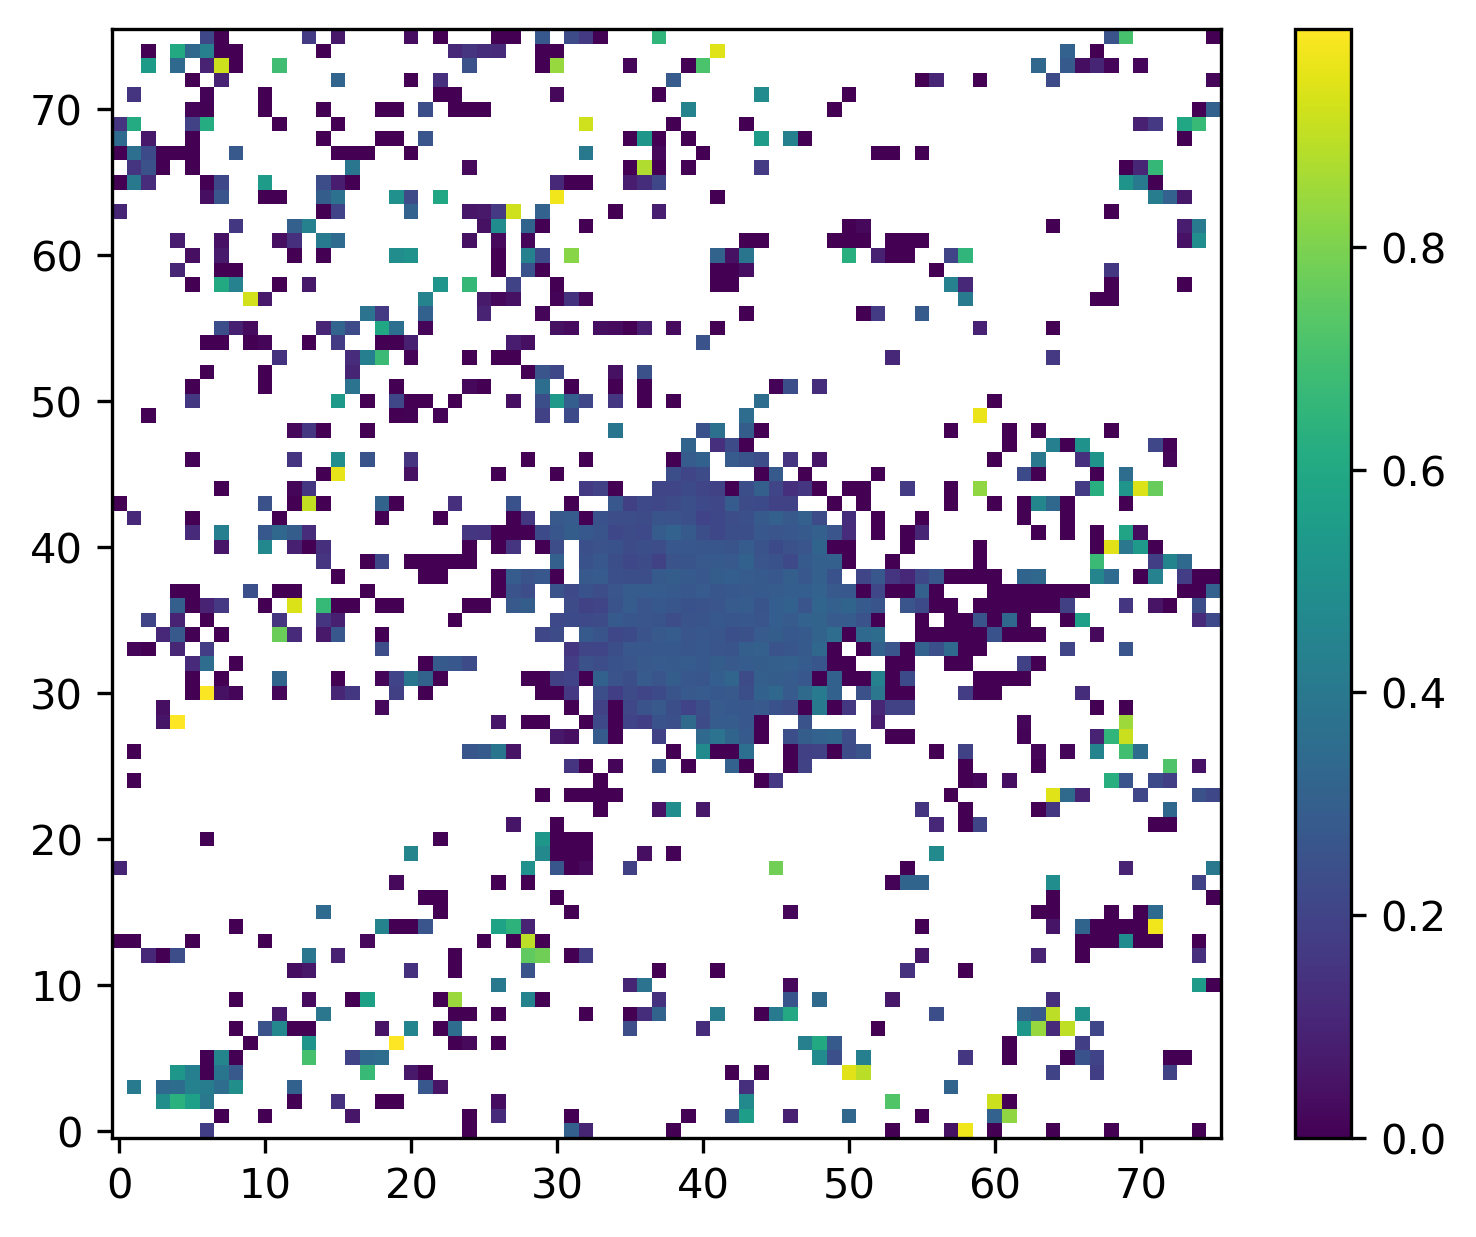

In [11]:
plt.imshow(maskedratio,origin='lower')
plt.colorbar()
plt.show()

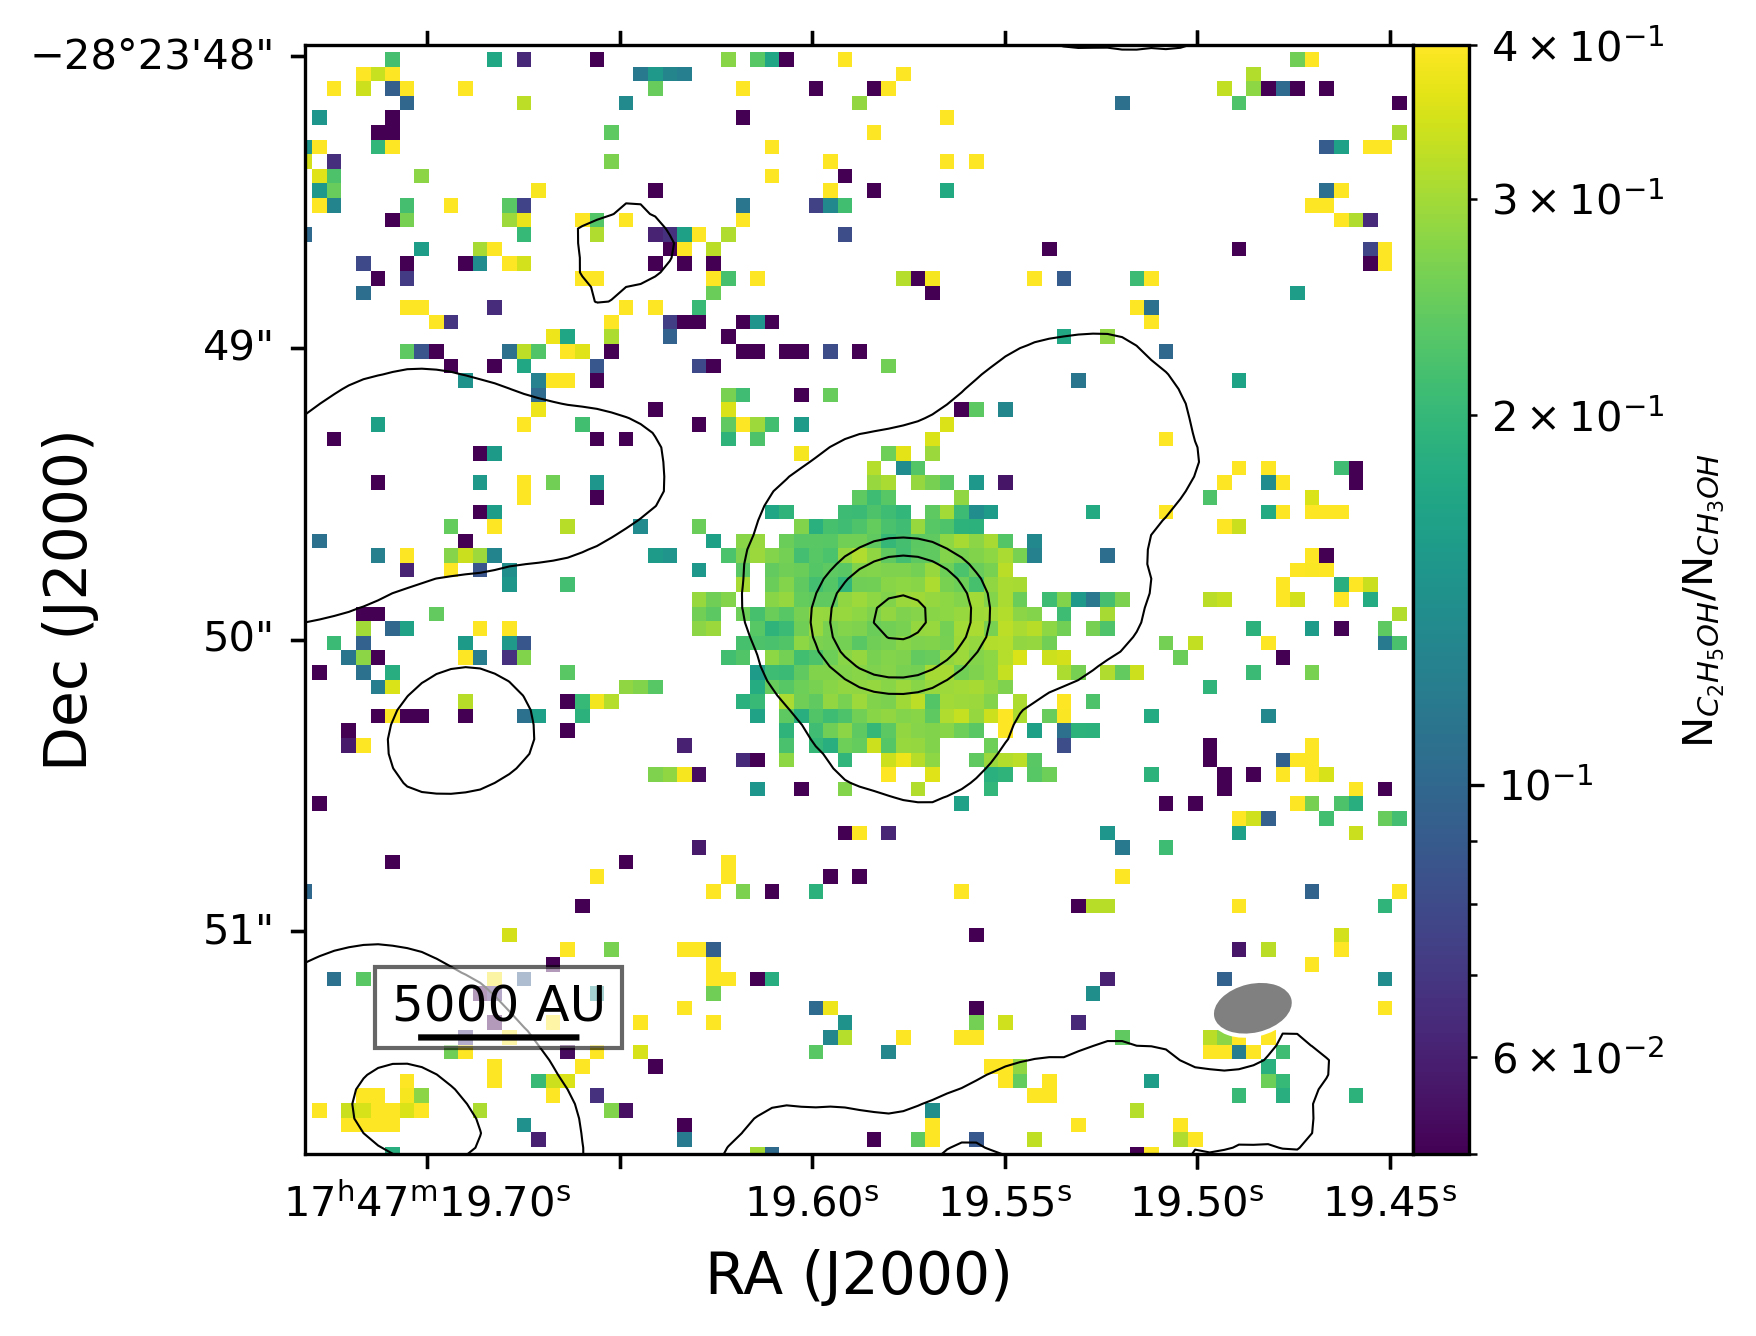

In [12]:
sliced=['x','y']
plt.figure()
ax=plt.subplot(projection=plotwcs,slices=sliced)
plt.rcParams['figure.dpi'] = 300

ra=ax.coords[0]
dec=ax.coords[1]
img=ax.imshow(maskedratio,norm=mpl.colors.LogNorm(vmax=source_plotnorms[0],vmin=source_plotnorms[1]),origin='lower')
ax.contour(cntrdata, levels=cntrlist, colors='black',transform=ax.get_transform(contourwcs),linewidths=0.5,zorder=1)
ra.set_axislabel('RA (J2000)',fontsize=14,minpad=0.9)
ra.set_ticklabel(exclude_overlapping=True)
dec.set_axislabel('Dec (J2000)',fontsize=14,minpad=-0.7)
ax.tick_params(fontsize=14)
plt.colorbar(img,pad=0,label=r'N$_{C_2H_5OH}$/N$_{CH_3OH}$')#plt.colorbar()
make_scalebar(ax, coordinates.SkyCoord(scalebar_position[0,0],scalebar_position[0,1], unit=u.deg, 
                                       frame='icrs'),
              length=lenn, label=f'{int(scale.value)} AU', fontsize=12, 
              text_offset=0.02*u.arcsec)
hdubeamplot=beam.ellipse_to_plot(beam_hor,beam_vert,pixscale)
ax.add_patch(hdubeamplot)

ax.set_ylim(0,h_img)
ax.set_xlim(0,l_img)
hdubeamplot.set_facecolor('gray')
hdubeamplot.set_edgecolor('white')
plt.savefig(savefigpath)
plt.show()

In [64]:
rawratiopath=ethanolhome+ethanol_dataversion+"nc2h5oh_nch3oh_ratio_raw.fits"
primaryhdu_rawratio=fits.PrimaryHDU(ratio)
primaryhdu_rawratio.header=ethanolhdu.header
primaryhdu_rawratio.header['BTYPE']='Ethanol/Methanol Abundance Ratio'
primaryhdu_rawratio.header['BUNIT']='unitless'
hdul_rawratio=fits.HDUList([primaryhdu_rawratio])
print(f'Saving ratio map at {rawratiopath}\n')
hdul_rawratio.writeto(rawratiopath,overwrite=True)

errorpath=ethanolhome+ethanol_dataversion+"nc2h5oh_nch3oh_ratio_error.fits"
primaryhdu_error=fits.PrimaryHDU(error_ratio)
primaryhdu_error.header=ethanolhdu.header
primaryhdu_error.header['BTYPE']='Ethanol/Methanol Abundance Ratio Error'
primaryhdu_error.header['BUNIT']='unitless'
hdul_error=fits.HDUList([primaryhdu_error])
print(f'Saving ratio map at {errorpath}\n')
hdul_error.writeto(errorpath,overwrite=True)

maskedpath=ethanolhome+ethanol_dataversion+"nc2h5oh_nch3oh_ratio_3sigma_lessthan1.fits"
primaryhdu_masked=fits.PrimaryHDU(maskedratio)
primaryhdu_masked.header=ethanolhdu.header
primaryhdu_masked.header['BTYPE']='Ethanol/Methanol Abundance Ratio'
primaryhdu_masked.header['BUNIT']='unitless'
hdul_masked=fits.HDUList([primaryhdu_masked])
print(f'Saving ratio map at {maskedpath}\n')
hdul_masked.writeto(maskedpath,overwrite=True)

Saving ratio map at /blue/adamginsburg/d.jeff/SgrB2DSreorg/field10/C2H5OH/DSii/oct2024_1_removeproblemlines/nc2h5oh_nch3oh_ratio_raw.fits

Saving ratio map at /blue/adamginsburg/d.jeff/SgrB2DSreorg/field10/C2H5OH/DSii/oct2024_1_removeproblemlines/nc2h5oh_nch3oh_ratio_error.fits

Saving ratio map at /blue/adamginsburg/d.jeff/SgrB2DSreorg/field10/C2H5OH/DSii/oct2024_1_removeproblemlines/nc2h5oh_nch3oh_ratio_3sigma_lessthan1.fits



In [12]:
contfreq=225*u.GHz
ds1=87*u.mJy

equiv=u.brightness_temperature(contfreq)
bmaj=0.35*u.arcsec
beamarea_sr=(np.pi*(bmaj/2)**2).to('sr')
mjysr=ds1/beamarea_sr
conv=mjysr.to('K',equivalencies=equiv)
print(conv)

24.73469959536386 K


In [11]:
beamarea_sr

<Quantity 2.26139123e-12 sr>